# Подключаем библиотеки

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

In [3]:
data_train = pd.read_csv('train.csv')
data_valid = pd.read_csv('valid.csv')

C:\Users\artem\AppData\Local\Temp\ipykernel_12024\326463787.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,1450

In [96]:
numeric_columns = data_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_train.select_dtypes(include=['object']).columns
boolean_columns = data_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_valid.select_dtypes(include=['object']).columns
boolean_columns = data_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 2319
Категориальные колонки в train.csv: 347
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 2332
Категориальные колонки в valid.csv: 334
Булевые колонки в valid.csv: 0


<h3> Очистка данных

In [4]:
# Сначала группируем по client_id, объединяя строки, заполняя пропуски значениями из других строк
data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
data_cleaned_valid = data_valid.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])

# Убедимся, что в результате не осталось дубликатов
data_cleaned_train = data_cleaned_train.drop_duplicates(subset='client_id')
data_cleaned_valid = data_cleaned_valid.drop_duplicates(subset='client_id')


C:\Users\artem\AppData\Local\Temp\ipykernel_12024\665574341.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
C:\Users\artem\AppData\Local\Temp\ipykernel_12024\665574341.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
C:\Users\artem\AppDat

In [5]:
# Удаление колонок, где все значения NaN
data_cleaned_train = data_cleaned_train.dropna(axis=1, how='all')
data_cleaned_train = data_cleaned_train.loc[:, (data_cleaned_train.notna()).mean() > 0.75]
data_cleaned_train = data_cleaned_train.drop_duplicates()
data_cleaned_train = data_cleaned_train[data_cleaned_train.notna().mean(axis=1) > 0.75]

data_cleaned_valid = data_cleaned_valid.dropna(axis=1, how='all')
# data_cleaned_valid = data_cleaned_valid.loc[:, (data_cleaned_valid.notna()).mean() > 0.75]
data_cleaned_valid = data_cleaned_valid.drop_duplicates()
# data_cleaned_valid = data_cleaned_valid[data_cleaned_valid.notna().mean(axis=1) > 0.75]

numeric_columns_train = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
# numeric_columns_valid = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns

# Заполняем пропуски только в числовых столбцах
imputer = SimpleImputer(strategy='median')
data_cleaned_train[numeric_columns_train] = imputer.fit_transform(data_cleaned_train[numeric_columns_train])
# data_cleaned_valid[numeric_columns_valid] = imputer.fit_transform(data_cleaned_valid[numeric_columns_valid])

# Сравнение до и после удаления
print(f"До удаления колонок (train.csv): {data_train.shape[1]} колонок")
print(f"После удаления колонок (train.csv): {data_cleaned_train.shape[1]} колонок")
print(f"Число строк до удаления (train.csv): {data_train.shape[0]}")
print(f"Число строк после удаления (train.csv): {data_cleaned_train.shape[0]}\n")
print(f"До удаления колонок (valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок (valid.csv): {data_cleaned_valid.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {data_cleaned_valid.shape[0]}")

До удаления колонок (train.csv): 2666 колонок
После удаления колонок (train.csv): 272 колонок
Число строк до удаления (train.csv): 14456
Число строк после удаления (train.csv): 4661

До удаления колонок (valid.csv): 2666 колонок
После удаления колонок (valid.csv): 2581 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 2932


In [8]:
test_data = data_cleaned_valid.copy()
test_data = test_data.dropna(axis=1, how='all')
# data_cleaned_valid = data_cleaned_valid.loc[:, (data_cleaned_valid.notna()).mean() > 0.75]
test_data = test_data.drop_duplicates()
print(f"До удаления колонок(valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок(valid.csv): {test_data.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {test_data.shape[0]}\n")

До удаления колонок(valid.csv): 2666 колонок
После удаления колонок(valid.csv): 2581 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 2932



<h3> Сохраняем очищенные данные

In [6]:
data_cleaned_train.to_csv('cleaned_train.csv', index=False)
data_cleaned_valid.to_csv('cleaned_valid.csv', index=False)

<h3> Обучаем модель

Баланс классов в целевой переменной:
target
0.0    0.981334
1.0    0.018666
Name: proportion, dtype: float64


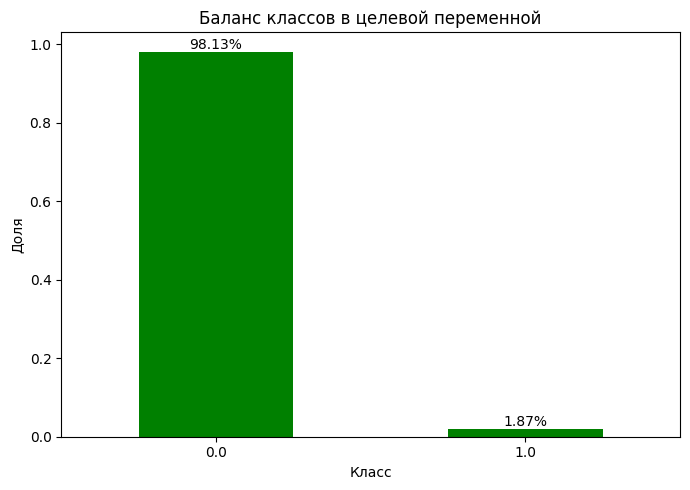

In [9]:
numeric_df_train = data_cleaned_train.select_dtypes(include=[np.number])
numeric_df_valid = test_data.select_dtypes(include=[np.number])
# Пример (должны быть признаки и целевая переменная)
X_train = numeric_df_train.drop(columns=['target', 'client_id'])  # Признаки
y_train = data_cleaned_train['target']                # Целевая переменная

# Вывод баланса классов для целевой переменной
class_balance = y_train.value_counts(normalize=True)
print("Баланс классов в целевой переменной:")
print(class_balance)

# Визуализация баланса классов
plt.figure(figsize=(7, 5))
class_balance.plot(kind='bar', color='green')
plt.title('Баланс классов в целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

d:\project\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
d:\project\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Баланс после SMOTE:
target
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


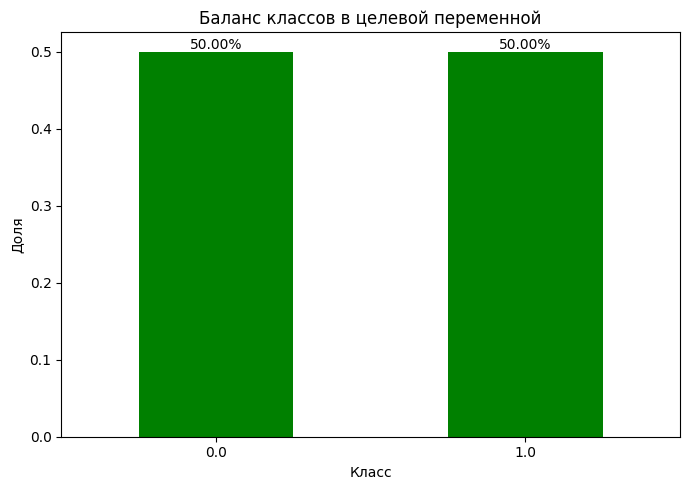

In [18]:
# Создаем объект SMOTE
smote = SMOTE(random_state=42)

# Применяем SMOTE
X_balanced_train, y_balanced_train = smote.fit_resample(X_train, y_train)

class_balance = y_balanced_train.value_counts(normalize=True)

# Проверяем баланс
print("Баланс после SMOTE:")
print(y_balanced_train.value_counts(normalize=True))
# Визуализация баланса классов
plt.figure(figsize=(7, 5))
class_balance.plot(kind='bar', color='green')
plt.title('Баланс классов в целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [29]:
y_balanced_train

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9143    1.0
9144    1.0
9145    1.0
9146    1.0
9147    1.0
Name: target, Length: 9148, dtype: float64

In [19]:
# 1. Масштабирование данных для PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced_train)

# 2. Применяем PCA
pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_pca = pca.fit_transform(X_scaled)

# 3. Определяем вклад признаков в каждую компоненту
components = pd.DataFrame(pca.components_, columns=X_balanced_train.columns)

# 4. Определяем признаки, наиболее влияющие на компоненты
important_features = set()
threshold = 0.1  # Порог значимости вклада признака
for component in components.values:
    feature_contributions = np.abs(component)  # Берем абсолютные значения вкладов
    important_features.update(X_balanced_train.columns[feature_contributions > threshold])

# 5. Сохраняем важные признаки в отдельную переменную
important_features = list(important_features)
X_selected = X_balanced_train[important_features]

print("Количество важных признаков:", len(important_features))
print("Важные признаки:", important_features)

Количество важных признаков: 137
Важные признаки: ['col2384', 'col2341', 'col1503', 'col1513', 'col2335', 'col2342', 'col1526', 'col2293', 'col1469', 'col2183', 'col2336', 'col2316', 'col2246', 'col1455', 'col1477', 'col1497', 'col1463', 'col2244', 'col1474', 'col1493', 'col1515', 'col1466', 'col2456', 'col2389', 'col2460', 'col1523', 'col2364', 'col1507', 'col1494', 'col2214', 'col2189', 'col1456', 'col2168', 'col2454', 'col2366', 'col2317', 'col2178', 'col2186', 'col2176', 'col1492', 'col2390', 'col2187', 'col2360', 'col1465', 'col1510', 'col1487', 'col2220', 'col1511', 'col1491', 'col1505', 'col2287', 'col1520', 'col1521', 'col2222', 'col1508', 'col2245', 'col2358', 'col2169', 'col1470', 'col1475', 'col2292', 'col2171', 'col1502', 'col1504', 'col1478', 'col2340', 'col2216', 'col2455', 'col2288', 'col2294', 'col2383', 'col1498', 'col1459', 'col1490', 'col2174', 'col1524', 'col2167', 'col1457', 'col2240', 'col2185', 'col2221', 'col2461', 'col1467', 'col2468', 'col2334', 'col2318', 'co

<h3> Тестируем модель

In [11]:
test_data = data_cleaned_valid.copy()
test_data = test_data[important_features]
# pd.concat([data_cleaned_train, data_train['target']], axis=1)
test_data = pd.concat([test_data, data_cleaned_valid['target']], axis=1)
test_data = test_data[test_data.notna().mean(axis=1) > 0.75]
test_data[important_features] = imputer.fit_transform(test_data[important_features])
test_data

,col2384,col2341,col1503,col1513,col2335,col2342,col1526,col2293,col1469,col2183,...,col2286,col1462,col2172,col2215,col1453,col2663,col2182,col1472,col1514,target
0,30.09,5794341.03,0.0,0.0,5.794341e+06,5.794341e+06,0.0,5.0,0.0,0.0,...,5.0,1.0,3.0,10000.0,0.0,0.256919,1.0,0.0,0.0,0
1,62.97,13953348.06,0.0,0.0,1.395335e+07,1.397187e+07,0.0,2.0,0.0,0.0,...,4.0,1.0,6.0,300.0,0.0,0.267221,2.0,0.0,0.0,0
2,3.34,318565.86,0.0,0.0,3.185659e+05,4.128387e+06,0.0,3.0,0.0,0.0,...,4.0,1.0,2.0,5000.0,0.0,0.256261,2.0,0.0,0.0,0
3,36.96,7002418.50,0.0,0.0,7.708613e+06,7.002418e+06,0.0,16.0,0.0,0.0,...,8.0,1.0,0.0,10000.0,0.0,0.256261,1.0,0.0,0.0,0
4,36.96,9426889.64,0.0,0.0,7.708613e+06,9.426890e+06,0.0,24.0,0.0,0.0,...,8.0,4.0,0.0,10000.0,0.0,0.254164,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,51.90,14053793.40,0.0,0.0,1.405379e+07,1.405379e+07,0.0,9.0,0.0,0.0,...,9.0,2.0,3.0,10000.0,0.0,0.318385,1.0,0.0,0.0,0
2928,35.35,7355203.80,0.0,0.0,7.355204e+06,7.355204e+06,0.0,1.0,0.0,0.0,...,1.0,1.0,3.0,10000.0,0.0,0.261504,1.0,0.0,0.0,0
2929,35.43,5691475.20,0.0,0.0,5.691475e+06,5.691475e+06,0.0,8.0,0.0,0.0,...,8.0,1.0,3.0,10000.0,0.0,0.262651,1.0,0.0,0.0,0
2930,36.96,16130694.80,0.0,0.0,7.708613e+06,1.613069e+07,0.0,7.0,0.0,0.0,...,8.0,1.0,0.0,10000.0,0.0,0.256261,1.0,0.0,0.0,0


In [24]:
numeric_df_train = X_balanced_train
numeric_df_train[important_features]

,col2384,col2341,col1503,col1513,col2335,col2342,col1526,col2293,col1469,col2183,...,col2382,col2286,col1462,col2172,col2215,col1453,col2663,col2182,col1472,col1514
0,37.880000,6.801884e+06,0.0,0.000000,6.801884e+06,6.801884e+06,0.0,15.000000,0.000000,0.000000,...,37.880000,15.000000,1.000000,0.000000,10000.000000,0.0,0.256261,1.000000,0.0,0.000000
1,30.090000,5.794341e+06,0.0,0.000000,5.794341e+06,5.794341e+06,0.0,5.000000,0.000000,0.000000,...,30.090000,5.000000,1.000000,3.000000,10000.000000,1.0,0.256919,1.000000,0.0,0.000000
2,21.045000,3.185659e+05,0.0,0.000000,3.185659e+05,4.128387e+06,0.0,3.000000,0.000000,0.000000,...,38.750000,4.000000,1.000000,6.000000,5000.000000,1.0,0.256261,2.000000,0.0,0.000000
3,36.750000,7.002418e+06,0.0,0.000000,7.002418e+06,7.002418e+06,0.0,16.000000,0.000000,0.000000,...,36.750000,16.000000,1.000000,0.000000,10500.000000,0.0,0.256261,1.000000,0.0,0.000000
4,35.560000,8.280004e+06,0.0,0.000000,8.280004e+06,8.280004e+06,0.0,8.000000,1.000000,0.000000,...,35.560000,8.000000,1.000000,1.000000,10000.000000,0.0,0.258682,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,57.695011,1.876280e+06,0.0,0.000000,1.876280e+06,1.057782e+07,0.0,-1.000000,0.000000,0.000000,...,72.858709,19.891616,1.162183,4.162183,8540.349648,0.0,0.246079,2.162183,0.0,0.000000
9144,43.123990,1.023429e+07,0.0,0.486442,1.023429e+07,1.023429e+07,0.0,10.377981,0.486442,0.486442,...,43.123990,10.377981,1.513558,3.000000,10000.000000,0.0,0.260222,1.000000,0.0,0.486442
9145,26.848307,5.727128e+06,0.0,0.000000,5.727128e+06,5.727128e+06,0.0,9.830227,1.477078,0.000000,...,26.848307,9.830227,1.738539,3.261461,10000.000000,0.0,0.256433,1.000000,0.0,0.000000
9146,39.070148,7.556757e+06,0.0,0.000000,7.556757e+06,7.556757e+06,0.0,17.269118,1.266290,0.000000,...,39.070148,17.269118,1.266290,3.000000,10000.000000,0.0,0.255856,1.000000,0.0,0.000000


In [30]:
# Разделение данных на обучающую и тестовую выборки
X_train = X_balanced_train
y_train = y_balanced_train
X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Масштабирование данных для ElasticNet
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[important_features])
X_test_scaled = scaler.transform(X_test[important_features])

# Обучение модели ElasticNet
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
y_pred_elastic = elastic_net.predict(X_test_scaled)

# Обучение модели на сокращенных данных
rf_reduced = RandomForestClassifier(random_state=42)
rf_reduced.fit(X_train[important_features], y_train)
y_pred_reduced = rf_reduced.predict(X_test[important_features])

# Оценка качества
print("Метрики для ElasticNet:")
print("Accuracy:", accuracy_score(y_test, y_pred_elastic))
print("F1-score:", f1_score(y_test, y_pred_elastic))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_elastic))

print("\nМетрики для RandomForest:")
print("Accuracy:", accuracy_score(y_test, y_pred_reduced))
print("F1-score:", f1_score(y_test, y_pred_reduced))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_reduced))

Метрики для ElasticNet:
Accuracy: 0.8966107497432386
F1-score: 0.05625
ROC-AUC: 0.5741181542152416

Метрики для RandomForest:
Accuracy: 0.9866484080794249
F1-score: 0.09302325581395349
ROC-AUC: 0.5263335457510214


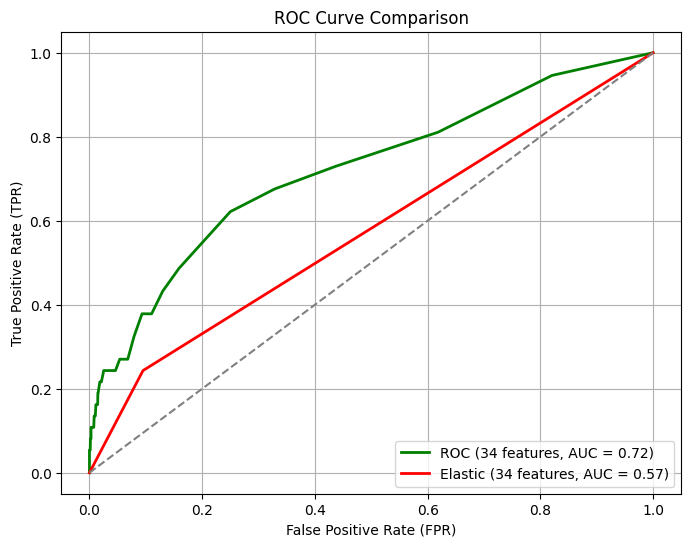

In [32]:
# Предсказания для модели RandomForest
y_pred_proba_reduced = rf_reduced.predict_proba(X_test[important_features])[:, 1]
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_pred_proba_reduced)
roc_auc_reduced = roc_auc_score(y_test, y_pred_proba_reduced)
fpr_reduced_elastic, tpr_reduced_elastic, _ = roc_curve(y_test, y_pred_elastic)
roc_auc_reduced_elastic = roc_auc_score(y_test, y_pred_elastic)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_reduced, tpr_reduced, color='green', lw=2, label=f'ROC (34 features, AUC = {roc_auc_reduced:.2f})')
plt.plot(fpr_reduced_elastic, tpr_reduced_elastic, color='red', lw=2, label=f'Elastic (34 features, AUC = {roc_auc_reduced_elastic:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h3> Сохраняем целевую переменную в тестируемых данных

In [107]:
# Сохранение предсказаний в целевой переменной
test_data['target'] = y_pred_reduced
test_data.to_csv('ready_valid.csv', index=False)